# Introduction
This notebook evaluates a Faster RCNN model trained with [this notebook](https://colab.research.google.com/drive/13KQoEpEG8vP76_OXHPJjgqI6lOxsaLxY#scrollTo=S557gOSdQgAi). The data used for this demo should therefore follow the structure described there.



In [ ]:
# mount drive, this should be set to the folder where the data folder is stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/DTU/Deep learning/FoodRecognition'

/content/drive/My Drive/DTU/Deep learning/FoodRecognition


## Define functions to be used

### Dataloader

In [ ]:
"""
Load data into a dataset class that can be used to train our model.
"""

import torchvision.datasets as datasets
import numpy as np
import torch
import torchvision.transforms as transforms
import os
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# dicts for converting classes to labels
classes = ['__background__', 'boiled peas', 'boiled potatoes', 'chopped lettuce', 'fried egg',
        'glass of milk', 'glass of water', 'meatballs', 'plain rice', 'plain spaghetti',
        'slice of bread']

cls_to_label_dict = {j:i for i,j in enumerate(classes)}
label_to_cls_dict = {i:j for i,j in enumerate(classes)}

class foodDataset(torch.utils.data.Dataset):
    """
    Class to store the food data
    """
    def __init__(self, data_root:str, datatype:str = "train", transforms = None):
      self.data_root = data_root
      self.transforms = transforms
      self.splitImgPath = data_root + "VOCdevkit/VOC2007/ImageSets/Main/" + datatype + ".txt"
      with open(self.splitImgPath, "r") as splitIdx:
        self.imgNames = splitIdx.readlines()

      # self.dataset = datasets.VOCDetection(data_root, year='2007', image_set = datatype, transform=self.transforms)
      self.dataset = datasets.VOCDetection(data_root, year='2007', image_set = datatype)

    def __getitem__(self, idx):
      img = self.dataset[idx][0]
      obs = self.dataset[idx][1]["annotation"]["object"]
      num_objs = len(obs)

      image_id = torch.tensor([int(os.path.splitext(self.dataset[idx][1]["annotation"]["filename"])[0])])

      boxes = []
      labels = torch.ones((num_objs,), dtype=torch.int64)
      for i in range(num_objs):
        xmin = int(obs[i]["bndbox"]["xmin"])
        xmax = int(obs[i]["bndbox"]["xmax"])
        ymin = int(obs[i]["bndbox"]["ymin"])
        ymax = int(obs[i]["bndbox"]["ymax"])
        boxes.append([xmin, ymin, xmax, ymax])
        cls = obs[i]["name"]
        try:
          labels[i] *= cls_to_label_dict[cls]
        except KeyError:
          raise KeyError(f"Image {image_id} had an unavailable label: {cls} ")
      boxes = torch.as_tensor(boxes, dtype=torch.float32)

      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

      # suppose all instances are not crowd
      iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
      
      target = {}
      target["boxes"] = boxes
      target["labels"] = labels
      target["area"] = area
      target["image_id"] = image_id
      target["iscrowd"] = iscrowd

      return (img, target) if self.transforms is None else self.transforms(img, target)

    def __len__(self):
      return len(self.imgNames)


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)
    

### Test function

In [ ]:
# test model
import os
def test_model(model_name, num_epochs, data_type):
  filename = f"models/{model_name}_epoch{num_epochs}.pth"
  assert os.path.isfile(filename), "Model does not exist"
  # use our dataset and defined transformations
  root = "data/VOC/"
  # transform = get_transform(train=True) if data_type == "train" else get_transform(train = False)
  dataset = foodDataset(root, data_type, transforms= get_transform(False))

  data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=1, shuffle=False, num_workers=4,
  collate_fn=utils.collate_fn)
  
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  # model = torch.load(f"models/opt_model/{model_name}_epoch{num_epochs}.pth")
  model = torch.load(filename)
  eval = evaluate(model, data_loader, device=device)
  
  return eval.coco_eval["bbox"].stats

# test_model("opt_model/model", 39, "test")

# root = "data/VOC/"
# dataset_test = foodDataset(root, "test", get_transform(train=False))
# data_loader_test = torch.utils.data.DataLoader(
#     dataset_test, batch_size=1, shuffle=False, num_workers=4,
#     collate_fn=utils.collate_fn)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# print(f"Device used is: {device}")
# model = torch.load("models/opt_model/model_epoch39.pth")
# evaluate(model, data_loader_test, device=device)

# Evaluate the models

In [ ]:
import pickle

epochs = 39
eval_train = {"epoch_"+str(i) : test_model("opt_model/model", i+1, "train") for i in range(epochs)}
with open("evaluation/train.pickle", "wb") as f:
  pickle.dump(eval_train, f)

eval_test = {"epoch_"+str(i) : test_model("opt_model/model", i+1, "test") for i in range(epochs)}
with open("evaluation/test.pickle", "wb") as f:
  pickle.dump(eval_test, f)

eval_val = {"epoch_"+str(i) : test_model("opt_model/model", i+1, "val") for i in range(epochs)}
with open("evaluation/val.pickle", "wb") as f:
  pickle.dump(eval_val, f)

while True: pass

# Show results

In [ ]:
import pickle
with open("evaluation/train.pkl", "rb") as f:
  eval_train = pickle.load(f)

with open("evaluation/test.pkl", "rb") as f:
  eval_test = pickle.load(f)

with open("evaluation/val.pkl", "rb") as f:
  eval_val = pickle.load(f)

train_plot_vals = [[eval_train["epoch_"+str(i)][j] for i in range(39)] for j in range(12)]
test_plot_vals = [[eval_test["epoch_"+str(i)][j] for i in range(39)] for j in range(12)]
val_plot_vals = [[eval_val["epoch_"+str(i)][j] for i in range(39)] for j in range(12)]

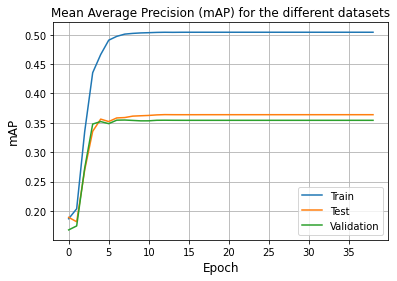

In [ ]:
import matplotlib.pyplot as plt
def plot_curve(idx):
  plt.plot(train_plot_vals[idx])
  plt.plot(test_plot_vals[idx])
  plt.plot(val_plot_vals[idx])
  plt.legend(["Train", "Test", "Validation"])
  plt.xlabel("Epoch", fontdict={"size":12})
  plt.title("Mean Average Precision (mAP) for the different datasets", fontdict={"size":12})
  plt.ylabel("mAP", fontdict={"size":12})
  
  # plt.xticks(list(set([i for i in range(0,39, 5)])), [list(set([i+1 for i in range(0,39, 5)])))
  # plt.xticks([i for i in range(0,39,5)])
  plt.grid()

# plt.figure(figsize=(15, 12))
plot_curve(0)
plt.savefig("validation_plot.png")
plt.show()

# plot all metrics - behaviour of the curve seems nearly identical
# plt.figure(figsize=(15, 12))
# for i in range(12):
#   plt.subplot(4, 3, i+1)
#   plot_curve(i)
# plt.show()

In [ ]:
print(f"mAP values: train = " + str(eval_train["epoch_38"][0]) + "\t test = " + str(eval_test["epoch_38"][0]) + "\t val = " + str(eval_val["epoch_38"][0]))
# eval_test["epoch_38"][0]

mAP values: train = 0.5041909866112427	 test = 0.3638583956496198	 val = 0.3542739649862209
